In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./assets/datasets/car.csv')
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


This time we will encode the features using a One Hot encoding scheme, i.e. we will consider them as categorical variables.

Since Scikit-Learn doesn't understand strings, but only numbers we will also need to map the labels to numbers. We can use the LabelEncoder we've encountered other times.

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['acceptability'])
X = pd.get_dummies(df.drop('acceptability', axis=1))

Let's train a decision tree on the whole dataset (ignore overfitting for the moment). Let's also artificially constrain the tree to be small so that we can visualize it.

In [20]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2)

dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Check: What does the next line of code do?

Answer: How many values there are for each class

In [21]:
pd.Series(y).value_counts()

2    1210
0     384
1      69
3      65
dtype: int64

Let's visualize the tree using the graphviz exporter. We previously encountered this in the lesson on decision trees.

Check: Can you fill the blanks?

In [ ]:
# from sklearn.externals.six import StringIO
# from sklearn.tree import export_graphviz
# import pydot
# from IPython.display import Image
# dot_data = StringIO()  
# export_graphviz(<fill here>, out_file=dot_data,  
#                 feature_names=<fill here>,  
#                 class_names=<fill here>,  
#                 filled=True, rounded=True,
#                 proportion=True,
#                 special_characters=True)  
# graph = pydot.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())  

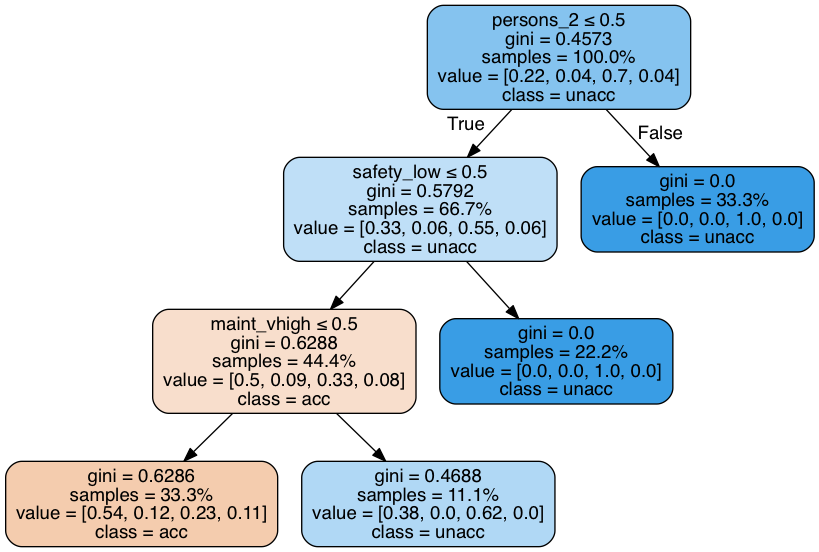

In [23]:

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
dot_data=StringIO()
export_graphviz(dt, out_file=dot_data,  
                feature_names=X.columns,  
                class_names=le.classes_,  
                filled=True, rounded=True,
                proportion=True,
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [31]:
C0

array([ 0.        ,  0.02040816,  0.04081633,  0.06122449,  0.08163265,
        0.10204082,  0.12244898,  0.14285714,  0.16326531,  0.18367347,
        0.20408163,  0.2244898 ,  0.24489796,  0.26530612,  0.28571429,
        0.30612245,  0.32653061,  0.34693878,  0.36734694,  0.3877551 ,
        0.40816327,  0.42857143,  0.44897959,  0.46938776,  0.48979592,
        0.51020408,  0.53061224,  0.55102041,  0.57142857,  0.59183673,
        0.6122449 ,  0.63265306,  0.65306122,  0.67346939,  0.69387755,
        0.71428571,  0.73469388,  0.75510204,  0.7755102 ,  0.79591837,
        0.81632653,  0.83673469,  0.85714286,  0.87755102,  0.89795918,
        0.91836735,  0.93877551,  0.95918367,  0.97959184,  1.        ])

The first choice involves person_2. If the car only takes 2 people (person_2 == 1) then the class is unacceptable. This happens in 33% of the cases. Note that the leaf under the False branch is 100% pure, and therefore it's Gini measure is 0.0.

On the other hand, if the car can hold more than 2 people, we will need to consider other choices. For example if the car is unsafe, then it's also unacceptable. And so on and so forth.

Check: Open discussion: What could be an advantage of using a decision tree in a model at work?

Answer: easier to communicate results and understand relevant features.


If the target is a classification taking values 0, 1, ... K-2, K-1. If node $m$ represents a region $R_m$ with $N_m$ observations, the proportion of class $k$ observations in node $m$ can be written as: $$ C_k = \frac{1}{N_m} \sum_{x_i\text{ in }R_m} I(y_i = k) $$ The Gini Index is then defined as: $$ \text{Gini}= \sum_{k=0}^{K-1} C_k (1 - C_k) = 1 - \sum_{k=0}^{K-1} C_k^2 $$

Let's plot the Gini index for various proportions in a binary classification:

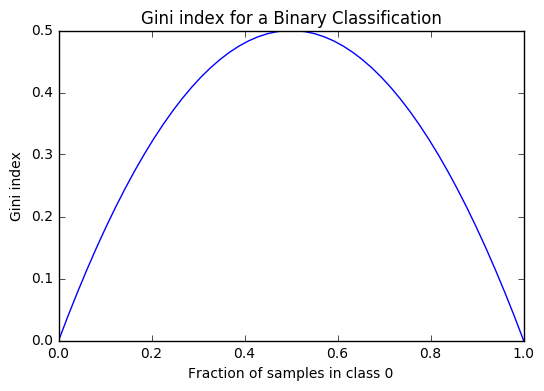

In [24]:
C0 = np.linspace(0,1)
C1 = 1.0 - C0

gini = 1 - C0**2 - C1**2

plt.plot(C0, gini)
plt.title('Gini index for a Binary Classification')
plt.xlabel('Fraction of samples in class 0')
plt.ylabel('Gini index')

Let's verify the calculation of the Gini index in the root node of the tree above:

In [25]:
root_node_values = [0.22, 0.04, 0.7, 0.04]

def gini(values):
    tot = 0.0
    for val in values:
        tot += val ** 2

    return 1.0 - tot

gini(root_node_values)

0.45840000000000003

Check: Check that the value we obtained is the same as the one appearing in our decision tree.

Great, now we are ready to look at feature importances in our tree:

In [26]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
safety_low,0.545239
persons_2,0.363493
maint_vhigh,0.091268
buying_high,0.000000
doors_5more,0.000000


Since we artificially constrained the tree to be small only 3 features are used to make splits. Let's verify the calculation of the importance.

In [27]:
gini_gain_persons_2  = 1.0   * 0.45728376  - 0.667 * 0.57923569 - 0.333 * 0.0
gini_gain_safety_low   = 0.666 * 0.57923569 - 0.444 * 0.62880113 - 0.222 * 0.0
gini_gain_buying_vhigh = 0.444 * 0.62880113 - 0.333 * 0.6285747 - 0.111 * 0.46875

norm = gini_gain_persons_2 + gini_gain_safety_low + gini_gain_buying_vhigh

print "persons_2:", gini_gain_persons_2 / norm
print "safety_low:", gini_gain_safety_low / norm
print "buying_vhigh:", gini_gain_buying_vhigh / norm

persons_2: 0.363095401091
safety_low: 0.545579514578
buying_vhigh: 0.0913250843306


safety_low is more important than persons_2 and buying_vhigh

In [29]:
print gini_gain_persons_2
print gini_gain_safety_low
print gini_gain_buying_vhigh

0.07093355477
0.10658326782
0.01784107662


Check: what did we just do and why did we do that?

Answer: We verified the calculation of Gini gain corresponds to the feature importance outputed by the decision tree model.

## Guided Practice: Feature importance in Ensemble models (25 min)

Scikit Learn implements feature importance for random forest and extra trees methods.

Let's train one of each of these and investigate the feature importance:

Random Forest
Extra Trees
Instructor: This could be done in small groups, where they have to fill the blanks of missing code.

In [32]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Random forest exposes the feature importance and it calculates it as the average feature importance of the trees. Let's verify that.

Fill the blanks in the code below:

In [35]:
# all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

# importances = rf.feature_importances_
# # calculate the standard deviation of feature importances by looping over the trees in the random forest
# # 
# std = ??

# indices = np.argsort(importances)[::-1]
# feature_names = X.columns

# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
# plt.xlim([-1, X.shape[1]])

Solution:

all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X.columns

(-1, 21)

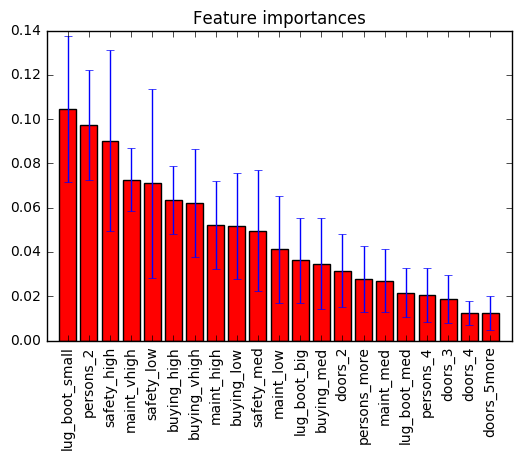

In [36]:
all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
# calculate the standard deviation of feature importances by looping over the trees in the random forest
# 
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])

Now it's your turn: repeat the investigation for the extra trees model.

(-1, 21)

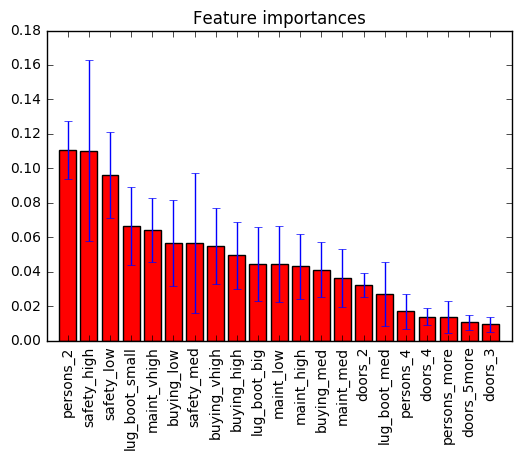

In [37]:
et.fit(X, y)

importances = et.feature_importances_
std = np.std([tree.feature_importances_ for tree in et.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])

Finally let's compare the 3 models (re-init Decision Tree):

,dt_importance,rf_importance,et_importance
lug_boot_small,0.094315,0.104612,0.066609
persons_2,0.233312,0.097518,0.110721
safety_high,0.074402,0.090300,0.110270
maint_vhigh,0.074033,0.072691,0.064288
safety_low,0.155542,0.070978,0.096245


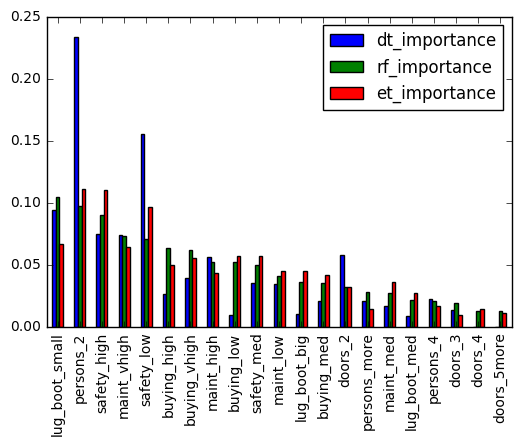

In [38]:
dt = DecisionTreeClassifier()
dt.fit(X, y)

importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)


importances.plot(kind='bar')
importances.head()

Check: Discuss in small groups the plot above. What are the common things across all models? What are the differences?

In this class we learned about feature importance and how they are calculated for tree based models. We have also deepened our understanding of the Gini measure.

Check: How can you use this in practice?

Answer: Have them discuss about feature selection and communicating results to peers